## Attention Analysis

below are original attention result，dimension is batch size * seq length * embedding dim

In [1]:
import pandas as pd
import numpy as np

input_file = open('model/pred_results/middle/attention_output.npy', 'rb')
attention_output = np.load(input_file)
input_file.close()
attention_output

array([[[[ 9.03357416e-02, -1.46252215e-01,  4.39273268e-02, ...,
          -2.36793071e-01, -1.18206963e-01, -3.19108605e-01],
         [ 1.16658546e-01,  1.79322883e-01, -3.64616513e-01, ...,
          -9.44611244e-03,  2.73034424e-01,  1.05977673e-02],
         [ 5.04213125e-02, -3.27972293e-01,  1.01155333e-01, ...,
          -2.77621537e-01, -5.24242401e-01, -1.35909602e-01],
         [ 1.36117756e-01,  2.68133730e-01,  9.39112455e-02, ...,
           1.15383957e-02, -1.36618584e-01,  7.51907974e-02]],

        [[ 8.36644322e-02, -1.95480883e-01,  5.41254804e-02, ...,
          -2.31987640e-01, -1.17652223e-01, -2.99079120e-01],
         [ 1.24643765e-01,  1.82985023e-01, -3.58616740e-01, ...,
          -8.10389221e-03,  2.75104225e-01,  1.34316753e-04],
         [ 3.33293915e-01, -4.76947844e-01, -2.42724746e-01, ...,
          -4.23521519e-01, -2.93256879e-01, -2.32465386e-01],
         [-7.99585357e-02,  1.49001226e-01,  6.31445721e-02, ...,
          -1.64377429e-02, -2.105987

Taking the average along the last dimension, we obtain the attention weights for each word, while also taking the absolute value. Due to the original data being subjected to pooling, we need to magnify it by a factor of 10 here.

In [2]:
mean_attention = np.mean(attention_output, axis=2)
mean_attention = np.abs(mean_attention)
mean_attention = np.repeat(mean_attention, 10, axis=1)
mean_attention

array([[[0.09838334, 0.00669197, 0.03140565, ..., 0.12808058,
         0.12650838, 0.09230742],
        [0.09838334, 0.00669197, 0.03140565, ..., 0.12808058,
         0.12650838, 0.09230742],
        [0.09838334, 0.00669197, 0.03140565, ..., 0.12808058,
         0.12650838, 0.09230742],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.08160198, 0.13058764, 0.07533316, ..., 0.02124031,
         0.16857412, 0.0556135 ],
        [0.08160198, 0.13058764, 0.07533316, ..., 0.02124031,
         0.16857412, 0.0556135 ],
        [0.08160198, 0.13058764, 0.07533316, ..., 0.02124031,
         0.16857412, 0.0556135 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

Based on the annotation information, extract the attention outputs for cases with annotations and without annotations, respectively.

In [3]:
import pickle

input_file = open('preprocess_data/middle/test_middle_annotation.pkl', 'rb')
test_middle_list = pickle.load(input_file)
input_file.close()
bio_annotation_area = []
no_annotation_area = []
for seq_no in range(len(mean_attention)):
    bio_annotation_area.append([])
    no_annotation_area.append([])
    if len(test_middle_list[seq_no]['annotation']) == 0:
        continue # skip if no annotation
    for idx in range(test_middle_list[seq_no]['seq_len']):
        flag = False
        for bio_idx in range(len(test_middle_list[seq_no]['annotation'])):
            if idx >= test_middle_list[seq_no]['annotation'][bio_idx]['start_rel'] and idx <= test_middle_list[seq_no]['annotation'][bio_idx]['end_rel']:
                bio_annotation_area[seq_no].append(mean_attention[seq_no][idx])
                flag = True
                break
        if not flag:
            no_annotation_area[seq_no].append(mean_attention[seq_no][idx])


IndexError: list index out of range

In [3]:
import pandas as pd
import numpy as np
input_file = open('/data/personal/baoyh/emo/model/pred_results/middle/attention_output.npy', 'rb')
attention_output = np.load(input_file)
input_file.close()

attention_output = attention_output[:, :, 1, :] # 0, 1, 3 significant

In [4]:
mean_attention = np.abs(attention_output)
mean_attention = np.mean(mean_attention, axis=2)
mean_attention = np.repeat(mean_attention, 10, axis=1)

Here, all the data is combined together for hypothesis testing.

In [5]:
import pickle
input_file = open('preprocess_data/middle/train_middle_annotation.pkl', 'rb')
test_middle_list = pickle.load(input_file)
input_file.close()
bio_annotation_area = []
no_annotation_area = []
for seq_no in range(len(mean_attention)):
    bio_annotation_area.append([])
    no_annotation_area.append([])
    if len(test_middle_list[seq_no]['annotation']) == 0:
        continue # skip if no annotation
    for idx in range(test_middle_list[seq_no]['seq_len']):
        flag = False
        for bio_idx in range(len(test_middle_list[seq_no]['annotation'])):
            if idx >= test_middle_list[seq_no]['annotation'][bio_idx]['start_rel'] and idx <= test_middle_list[seq_no]['annotation'][bio_idx]['end_rel']:
                bio_annotation_area[seq_no].append(mean_attention[seq_no][idx])
                flag = True
                break
        if not flag:
            no_annotation_area[seq_no].append(mean_attention[seq_no][idx])

from scipy.stats import mannwhitneyu, ttest_ind
p_values = []
bio_total = []
no_total = []
for seq_no in range(len(bio_annotation_area)):
    if len(bio_annotation_area[seq_no]) == 0 or len(no_annotation_area[seq_no]) == 0:
        # p_values.append(100)
        continue
    if len(bio_annotation_area[seq_no]) > 3 * len(no_annotation_area[seq_no]):
        # p_values.append(100)
        continue
    bio_total.extend(bio_annotation_area[seq_no])
    no_total.extend(no_annotation_area[seq_no])
    # p_values.append(mannwhitneyu(bio_annotation_area[seq_no], no_annotation_area[seq_no], alternative='greater')[1])
print(mannwhitneyu(bio_total, no_total, alternative='greater')[1])

2.4017007483753314e-43


We will now proceed with segment visualization. Please note that in the heatmap visualization below, any values below 0.1 have been replaced with 0.1 to enhance the differentiation.

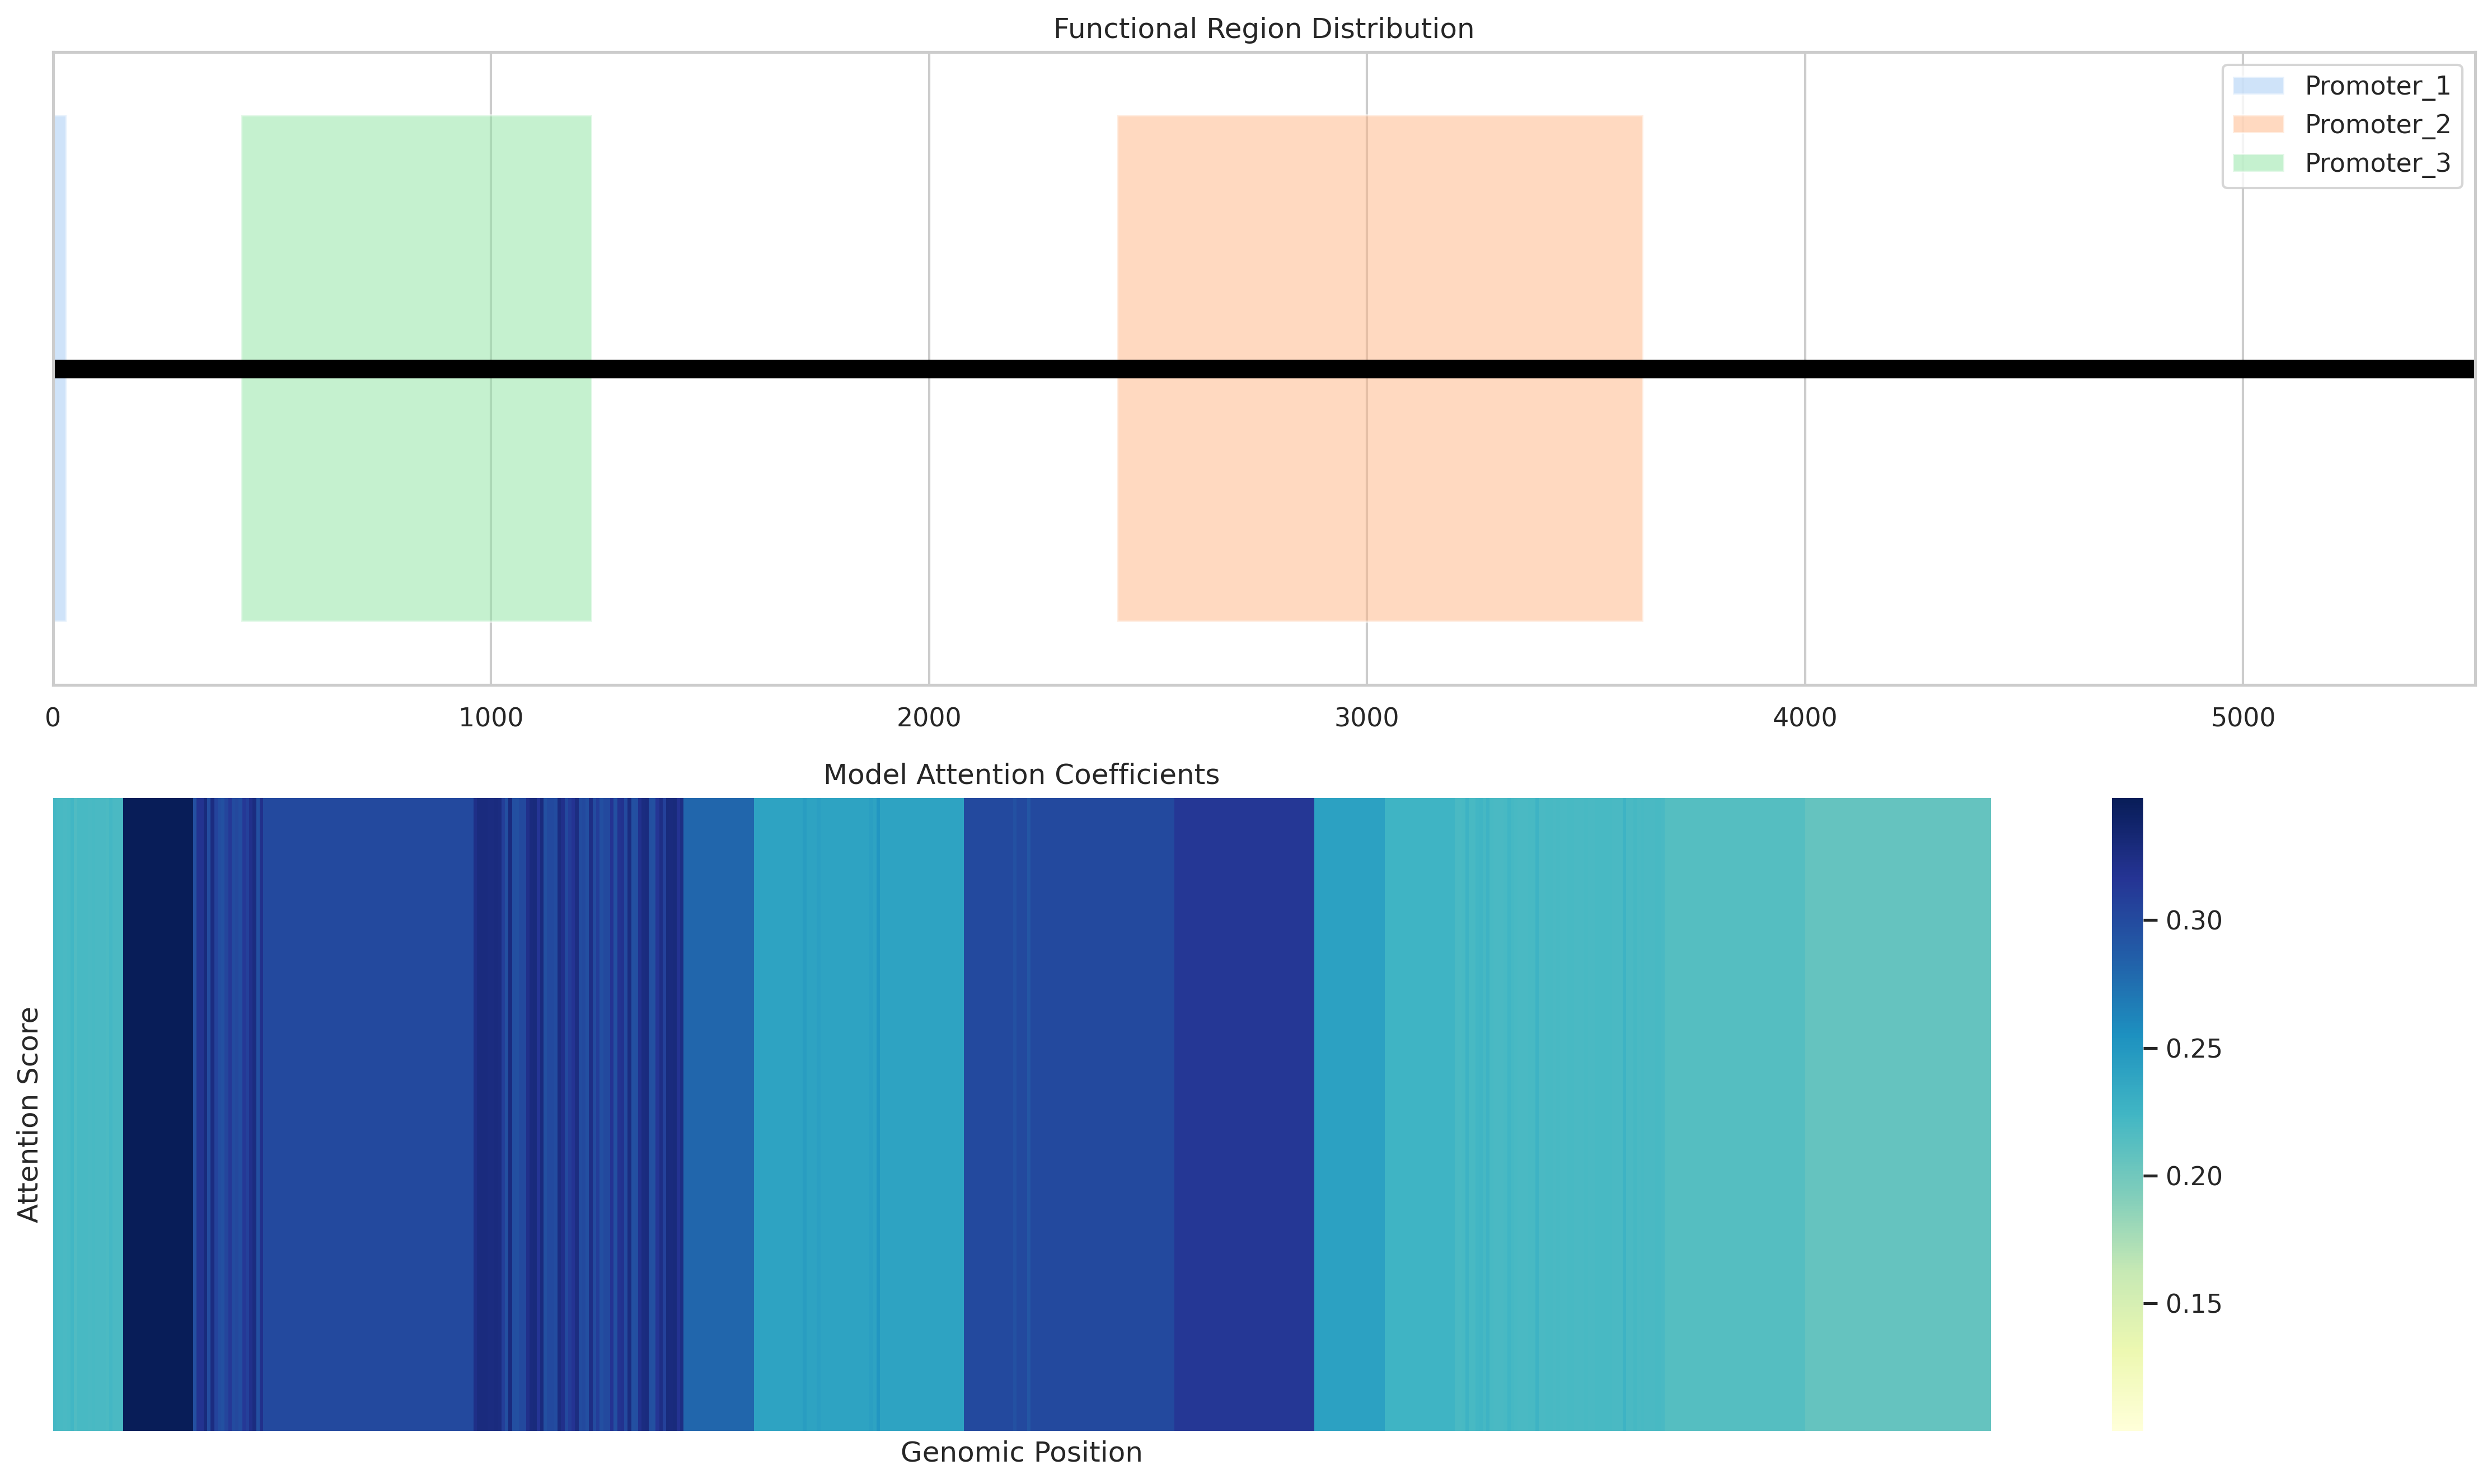

In [27]:
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
regulation_annotation = pd.read_table('preprocess_data/regulation_annotation.tsv', sep='\t')
need = 367

for seq_no in range(len(bio_annotation_area)):
    if len(bio_annotation_area[seq_no]) == 0 or len(no_annotation_area[seq_no]) == 0:
        continue
    if len(bio_annotation_area[seq_no]) > 3 * len(no_annotation_area[seq_no]):
        continue
    p_value = mannwhitneyu(bio_annotation_area[seq_no], no_annotation_area[seq_no], alternative='greater')[1]
    if p_value >= 0.0001:
        continue
    if seq_no != need:
        continue   # 找好看的case
    gene_start = 0
    gene_end = test_middle_list[seq_no]['seq_len'] - 1
    functional_regions = {}
    find_list = []
    for annotate in test_middle_list[seq_no]['annotation']:
        find_list.append(annotate['no'])
    k = regulation_annotation.iloc[find_list]
    feature_list = k['Feature type'].tolist()
    functional_regions_name_idx = {'Enhancer': 0, 'TF binding': 0, 'CTCF Binding Site': 0, 'Open chromatin': 0,
       'Promoter': 0}
    functional_regions = {}
    for idx in range(len(feature_list)):
        functional_regions_name_idx[feature_list[idx]] += 1
        functional_regions[feature_list[idx] + '_' + str(functional_regions_name_idx[feature_list[idx]])] = (test_middle_list[seq_no]['annotation'][idx]['start_rel'], test_middle_list[seq_no]['annotation'][idx]['end_rel'])
    attention_scores = mean_attention[seq_no]
    plt.figure(figsize=(15, 9), dpi=300)

    # 上面的子图显示基因片段
    plt.subplot(2, 1, 1)
    plt.plot([gene_start, gene_end], [0, 0], color='black', linewidth=8)
    plt.xlim(gene_start, gene_end)
    plt.ylim(-0.5, 0.5)
    plt.yticks([])
    plt.title('Functional Region Distribution')

    # 在基因片段上根据功能区分布信息绘制不同功能区的区域
    for region, (start, end) in functional_regions.items():
        plt.fill_between([start, end], [-0.4, -0.4], [0.4, 0.4], alpha=0.5, label=region)

    plt.legend(loc='upper right')


    sns.set_style('white')
    cmap = "YlGnBu"
    attention_scores[attention_scores < 0.1] = 0.1
    attention_matrix = np.array([attention_scores])

    plt.subplot(2, 1, 2)
    sns.heatmap(attention_matrix, cmap=cmap, xticklabels=False, yticklabels=False, cbar=True)
    plt.xlim(gene_start, gene_end)
    plt.ylim(0, 1)
    plt.xlabel('Genomic Position')
    plt.ylabel('Attention Score')
    plt.title('Model Attention Coefficients')

    plt.tight_layout()

    plt.show()
    break

The current requirement is to visualize examples within the same graph

 86%|████████▌ | 4967/5787 [00:10<00:01, 513.37it/s]

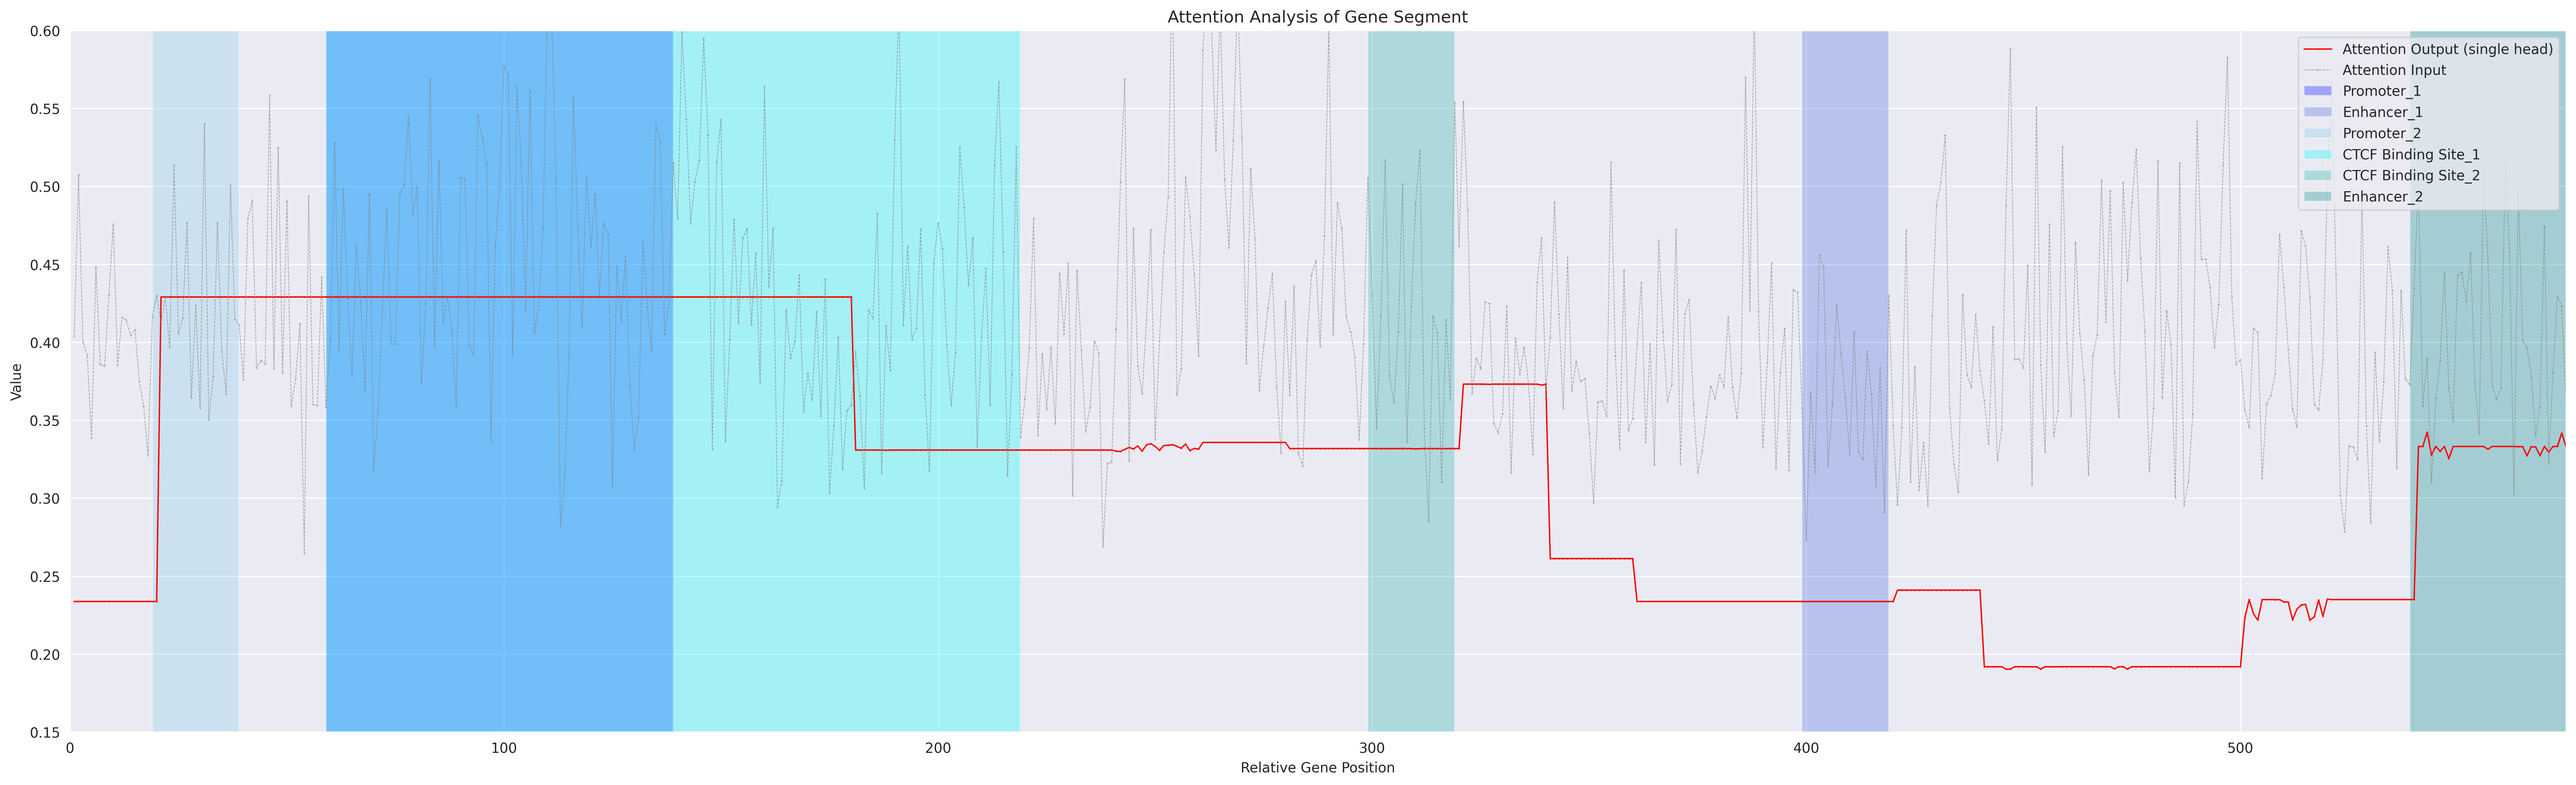

 86%|████████▌ | 4981/5787 [00:12<00:01, 413.02it/s]


In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

input_file = open('/data/personal/baoyh/emo/model/pred_results/middle/attention_output.npy', 'rb')
attention_output = np.load(input_file)
input_file.close()

input_file = open('/data/personal/baoyh/emo/model/pred_results/middle/attention_input.npy', 'rb')
attention_input = np.load(input_file)
input_file.close()

attention_output = attention_output[:, :, 1, :]

mean_attention = np.abs(attention_output)
mean_attention = np.mean(mean_attention, axis=2)
mean_attention = np.repeat(mean_attention, 10, axis=1)

mean_attention_input = np.abs(attention_input)
mean_attention_input = np.mean(mean_attention_input, axis=2)
mean_attention_input = np.repeat(mean_attention_input, 10, axis=1)


input_file = open('preprocess_data/middle/train_middle_annotation.pkl', 'rb')
test_middle_list = pickle.load(input_file)
input_file.close()
bio_annotation_area = []
no_annotation_area = []
for seq_no in tqdm(range(len(mean_attention))):
    bio_annotation_area.append([])
    no_annotation_area.append([])
    if len(test_middle_list[seq_no]['annotation']) == 0:
        continue # skip if no annotation
    for idx in range(test_middle_list[seq_no]['seq_len']):
        flag = False
        for bio_idx in range(len(test_middle_list[seq_no]['annotation'])):
            if idx >= test_middle_list[seq_no]['annotation'][bio_idx]['start_rel'] and idx <= test_middle_list[seq_no]['annotation'][bio_idx]['end_rel']:
                bio_annotation_area[seq_no].append(mean_attention[seq_no][idx])
                flag = True
                break
        if not flag:
            no_annotation_area[seq_no].append(mean_attention[seq_no][idx])

from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.interpolate import interp1d
regulation_annotation = pd.read_table('preprocess_data/regulation_annotation.tsv', sep='\t')
color_list = ['#0000FF', '#4169E1', '#87CEEB', '#00FFFF', '#20B2AA', '#008B8B']
need = 4981
# def polynomial_func(x, *params):
#     return np.polyval(params, x)
for seq_no in tqdm(range(len(bio_annotation_area))):
    if len(bio_annotation_area[seq_no]) == 0 or len(no_annotation_area[seq_no]) == 0:
        continue
    if len(bio_annotation_area[seq_no]) > 3 * len(no_annotation_area[seq_no]):
        continue
    p_value = mannwhitneyu(bio_annotation_area[seq_no], no_annotation_area[seq_no], alternative='greater')[1]
    if p_value >= 0.0001:
        continue
    if seq_no != need:
        continue   # 找好看的case
    gene_start = 0
    gene_end = test_middle_list[seq_no]['seq_len'] - 1
    functional_regions = {}
    find_list = []
    for annotate in test_middle_list[seq_no]['annotation']:
        find_list.append(annotate['no'])
    k = regulation_annotation.iloc[find_list]
    feature_list = k['Feature type'].tolist()
    functional_regions_name_idx = {'Enhancer': 0, 'TF binding': 0, 'CTCF Binding Site': 0, 'Open chromatin': 0,
       'Promoter': 0}
    functional_regions = {}
    for idx in range(len(feature_list)):
        functional_regions_name_idx[feature_list[idx]] += 1
        functional_regions[feature_list[idx] + '_' + str(functional_regions_name_idx[feature_list[idx]])] = (test_middle_list[seq_no]['annotation'][idx]['start_rel'], test_middle_list[seq_no]['annotation'][idx]['end_rel'])
    attention_scores = mean_attention[seq_no]
    input_attention_scores = mean_attention_input[seq_no]
    attention_scores = attention_scores[::10]
    input_attention_scores = input_attention_scores[::10]
    gene_positions = np.arange(1, len(attention_scores) + 1)

    # 绘制注意力系数信号峰图
    plt.figure(figsize=(26, 8), dpi=300)
    plt.plot(gene_positions, attention_scores, marker='.', linestyle='-', color='red', markersize=0.5, linewidth=1, label='Attention Output (single head)')
    plt.plot(gene_positions, input_attention_scores, marker='.', linestyle='--', color='gray', markersize=0.5, linewidth=0.5, alpha=0.7, label='Attention Input')
    plt.xlabel('Relative Gene Position')
    plt.ylabel('Value')
    plt.title('Attention Analysis of Gene Segment')
    color_count = 0
    for region, (start, end) in functional_regions.items():
        plt.fill_between([start // 10, end // 10], [0.15, 0.15], [0.6, 0.6], alpha=0.3, label=region, facecolor=color_list[color_count])
        color_count += 1

    plt.legend(loc='upper right')

    plt.xlim(gene_start // 10, gene_end // 10)
    plt.ylim(0.15, 0.6)
    plt.tight_layout()
    plt.show()
    break